# Michael Schor Notebook

## Dependencies

In [1]:
!pip install pillow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

In [2]:
train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
test_data_dir = 'ZhangLabData/CellData/chest_xray/test'

#Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
       test_data_dir, 
       target_size=(64, 64), batch_size=132)

#Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_data_dir, 
       target_size=(64, 64), batch_size=790)

#Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


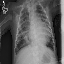

In [3]:
array_to_img(train_images[0])

In [4]:
print(train_labels[0])

[0. 1.]


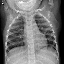

In [5]:
array_to_img(train_images[90])

In [6]:
print(train_labels[90])

[1. 0.]


In [7]:
print('train images shape: ',np.shape(train_images))
print('train labels shape: ',np.shape(train_labels))
print('test images shape: ',np.shape(test_images))
print('test labels shape: ',np.shape(test_labels))

train images shape:  (790, 64, 64, 3)
train labels shape:  (790, 2)
test images shape:  (132, 64, 64, 3)
test labels shape:  (132, 2)


In [8]:
#train set
train_img_unrow = train_images.reshape(790, -1)
train_img_unrow.shape

(790, 12288)

In [9]:
#test set
test_img_unrow = test_images.reshape(132, -1)
test_img_unrow.shape

(132, 12288)

In [10]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [11]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [12]:
#training set
train_labels_final = np.reshape(train_labels[:,0], (790,1))

In [13]:
np.shape(train_labels_final)

(790, 1)

In [14]:
test_labels_final = np.reshape(test_labels[:,0], (132,1))

In [15]:
np.shape(test_labels_final) 

(132, 1)

In [16]:
#scaling the data
train_img_final = train_img_unrow/255
test_img_final = test_img_unrow/255

type(test_img_unrow)

numpy.ndarray

In [17]:
print(train_img_final.shape)
print(test_img_final.shape)

(790, 12288)
(132, 12288)


## Baseline Model

In [18]:
np.random.seed(42)
model = models.Sequential()
model.add(layers.Dense(63, activation='relu', input_shape=(12288,)))
model.add(layers.Dense(42, activation='relu'))
model.add(layers.Dense(21, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [19]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(train_img_final,
                    train_labels_final,
                    epochs=50,
                    batch_size=32,
                    validation_data=(test_img_final, test_labels_final))

Epoch 1/50
25/25 [==============================] - 0s 9ms/step - loss: 0.5633 - accuracy: 0.7418 - val_loss: 0.6429 - val_accuracy: 0.6894
Epoch 2/50
25/25 [==============================] - 0s 3ms/step - loss: 0.5245 - accuracy: 0.7430 - val_loss: 0.6320 - val_accuracy: 0.6894
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4928 - accuracy: 0.7443 - val_loss: 0.5114 - val_accuracy: 0.6894
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.4603 - accuracy: 0.7684 - val_loss: 0.5755 - val_accuracy: 0.6894
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.4582 - accuracy: 0.7962 - val_loss: 0.4921 - val_accuracy: 0.6970
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.4350 - accuracy: 0.7987 - val_loss: 0.4350 - val_accuracy: 0.7348
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 0.3355 - accuracy: 0.8633 - val_loss: 0.3701 - val_accuracy: 0.8182
Epoch 8/50
25/25 [==

In [20]:
results_train = model.evaluate(train_img_final, train_labels_final)

25/25 [==============================] - 0s 998us/step - loss: 0.0968 - accuracy: 0.9620


In [21]:
results_test = model.evaluate(test_img_final, test_labels_final)

5/5 [==============================] - 0s 1ms/step - loss: 0.3772 - accuracy: 0.8636


#### Training accuracy = 0.9709. Test acc = 0.8788. Subsequent models must improve these thresholds.

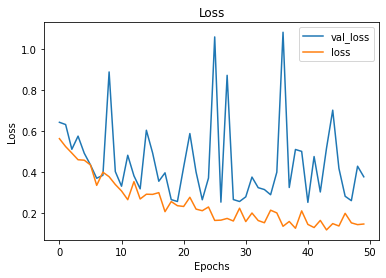

In [22]:
#plot acc vs loss for train and test set
history = results.history
plt.figure()
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show();

Insight: according to the Loss plot, there is significant overfitting of the model due to the high variation of the validation curve, as well as the divergence of the two curves themselves. Any subsequent models must reduce the variance and overfitting of the baseline model.

For CNN: create convolution filter, padding (and maybe striding?) and pooling layer (if there are too many features)